Challange: Use a pretrained ResNet 18 and train on the Flowers dataset. Use image transforms without using discriminative learning or 1 cycle scheduling and measure its effect on your model's performance.

In [1]:
#import section

In [133]:
import pandas as pd
import os
import torch
import json
import time
import copy
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader 
from torchvision import datasets, models, transforms


In [134]:
#path to folder with images files for model training
THIS_FOLDER = os.path.abspath('')
root_dir = os.path.join(THIS_FOLDER, 'oxford-102-flowers/')

In [135]:
class FlowersDataset(Dataset):
    """Flowers dataset."""
    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            txt_file (string): Path to the txt file with image names and labels.
            root_dir (string): Base Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.flowers = pd.read_csv(txt_file, delimiter = " ")
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.flowers)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.flowers.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.flowers.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'label': label, 'name': self.flowers.iloc[idx, 0]}
        return sample


In [136]:
#transformation for the train, validation and test sets.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [137]:
#read from JSON dictionary for the category (label) to name of the flowers
with open(os.path.join(THIS_FOLDER, 'oxford-102-flowers/cat_to_name.json')) as json_file:
    cat_to_name = json.load(json_file)

In [138]:
# train with GPU or CPU...in my case only cpu avalible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [139]:
#loading the data for train, validation and test sets
image_datasets = {x : FlowersDataset(txt_file= os.path.join(THIS_FOLDER, 'oxford-102-flowers/', 
                                                            x+'.txt'), root_dir=root_dir, 
                                transform = data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x : DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'valid']}
dataloaders = {x : DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


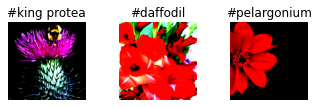

In [140]:
#Visualize a few images
fig = plt.figure()
for i in range(len(image_datasets)):
    sample = image_datasets['train'][i]

    #print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    label = str(sample['label'])
    ax.set_title('#{}'.format(cat_to_name[label]))
    ax.axis('off')
    img = sample['image']
    img = img.permute(1, 2, 0)
    #print (img)
    plt.imshow(img)
    #plt.imshow()
    if i == 3:
        plt.show()
        break


In [141]:
#general function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, batch in enumerate(dataloaders[phase]):
                inputs = batch['image']
                #print (inputs)
                inputs = inputs.to(device)
                labels = batch['label']
                labels = labels.to(device)
                #print (labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [142]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 102.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 102)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [143]:
train = False # train model or load saved trained model
if train: 
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
    num_epochs=25)
    #save the model
    dest_dir = None
    torch.save(model_ft.state_dict(), os.path.join(THIS_FOLDER, 'oxford-102-flowers/chechpoint.pth'))
else:
    model_ft.load_state_dict(torch.load(os.path.join(THIS_FOLDER, 'oxford-102-flowers/chechpoint.pth'))) 
    pass

In [147]:
#test our model on the test set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, batch in enumerate(dataloaders['test']):
            inputs = batch ['image']
            labels = batch ['label']
            inputs = inputs.to(device)
            #print (inputs)
            labels = labels.to(device)
            #print (labels)
            outputs = model(inputs)
            #print (outputs)
            _, preds = torch.max(outputs, 1)
            #print (preds)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(cat_to_name[str(preds[j].item())]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

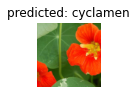

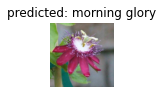

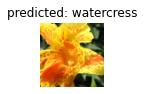

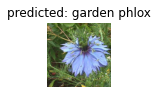

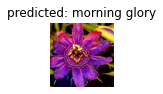

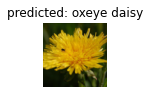

In [148]:
visualize_model(model_ft)